In [1]:
# constants
L = (2*360)/1000 # m
run = [1+i for i in range(6)] # run number
hv = [0.5 for i in range(6)] # L/min, hot flow rate
# co-current flow values
co_cv = [0.31, 0.5, 0.8, 1.1, 1.59, 1.9] #L/min, cold flow rate
co_T1 = [55.6, 60.8, 61.7, 62.1, 62.1, 61.8] #°C, Th, in
co_T3 = [45.5, 48.6, 48, 47.4, 46.6, 44.9] #°C, Th, out
co_T4 = [21.7, 22.6, 23.8, 23.8, 24.4, 20.3] #°C, Tc, in
co_T6 = [33.5, 33.7, 32.1, 30.5, 29, 24.8] #°C, Tc, out

# counter-current flow values
cc_cv = [0.3, 0.51, 0.8, 1.1, 1.61, 1.91] #L/min, cold flow rate
cc_T1 = [62.7, 62.3, 62.3, 62, 61.8, 61.6] #°C, Th, in
cc_T3 = [50.2, 48.1, 46.4, 45.4, 44.4, 43.9] #°C, Th, out
cc_T4 = [20.4, 19.9, 20, 19.5, 18.6, 18.5] #°C, Tc, in
cc_T6 = [38.4, 33.7, 30, 27.3, 24.2, 23.2] #°C, Tc, out

In [3]:
import math
def density(T):
    p = -13.851 + 0.64038*T - 0.0019124*(T**2) + 1.8211e-06*(T**3) # mol/dm^3
    # convert to kg/L
    p = p*18.01528/1000
    return p 

def cp(T):
    cp = 276370 - 2090.1*T + 8.125*(T**2) - 0.014116*(T**3) + 9.3701e-06*(T**4) # J/kmol K
    # convert to J/kg K
    cp = cp/18.01528
    return cp 

def visc(T):
    visc = math.exp(-52.843 + 3703.6/(T) + 5.866*math.log(T) - 5.879e-29*(T**10))
    return visc # Pas

def kf(T):
    k = -0.432 + 0.0057255*T - 8.078e-06*(T**2) + 1.861e-09*(T**3)
    return k # W/m K

def Nu(Re, Pr, D):
    if Re < 2300: # laminar
        Nu = (3.66**3 + 1.61**3 * Re * Pr * (D / L))**(1/3)
    else: # transitional flow
        Nu = 0.012 * (Re**0.87 - 280) * Pr**0.4 * (1 + (D/L)**(2/3))
    return Nu

def pr(T):
    pr = cp(T)*visc(T)/kf(T)
    return pr

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
k = 15 # W/m K, stainless steel
di = 10/1000 # m
do = 12/1000 # m
ds = 16/1000 # m
dh = ds - do # m
Ao = math.pi*(do)*L # m^2

qco_h_list = []
qco_c_list = []
Eloss_co = []
HTE_co = []
qcc_h_list = []
qcc_c_list = []
Eloss_cc = []
HTE_cc = []
Reshell_co = []
Reshell_cc = []
Qco_list = []
Uco_e = []
Uco_t = []
Qcc_list = []
Ucc_e = []
Ucc_t = []
Uco_error = []
Ucc_error = []
for i in range(6):
    # co-current flow calculations, hot water
    Tco_h = (co_T1[i]+co_T3[i])/2 + 273.15 # average hot temperature in K
    mco_h = 0.5*(density(Tco_h))/60 # kg/s
    cpco_h = cp(Tco_h) # J/kg K
    qco_h = mco_h*cpco_h*(co_T1[i]-co_T3[i]) # J/s
    qco_h_list.append(qco_h)
    # co-current flow calculations, cold water
    Tco_c = (co_T4[i]+co_T6[i])/2 + 273.15 # average cold temperature in K
    mco_c = co_cv[i]*(density(Tco_c))/60 # kg/s
    cpco_c = cp(Tco_c) # J/kg K
    qco_c = mco_c*cpco_c*(co_T6[i]-co_T4[i]) # J/s
    qco_c_list.append(qco_c)

    # co-current flow calculations, energy loss
    Eloss_co.append(qco_h-qco_c) # J/s

    # co-current flow calculations, heat transfer efficiency
    HTE_co.append(qco_c*100/qco_h) # uncertain 

    # co-current flow calculations, experimental overall heat transfer coefficient
    Qco = (qco_h+qco_c)/2 # J/s
    Qco_list.append(Qco)
    LMTD_co = ((co_T1[i]-co_T4[i])-(co_T3[i]-co_T6[i]))/math.log((co_T1[i]-co_T4[i])/(co_T3[i]-co_T6[i])) # K
    Uo_co = Qco/(Ao*LMTD_co) # W/m^2 K
    Uco_e.append(Uo_co) # experimental value

    # co-current flow calculations, theoretical overall heat transfer coefficient
    Reh_co = 4*mco_h/(math.pi*di*visc(Tco_h)) # Reynolds number for hot
    Prh_co = pr(Tco_h) # Prandtl number for hot
    Nu_h_co = Nu(Reh_co, Prh_co, di) # Nusselt number for hot
    k_h_co = kf(Tco_h) # W/m K
    hi_co = Nu_h_co*k_h_co/di # W/m^2 K
    Rec_co = 4*mco_c/(math.pi*dh*visc(Tco_c)) # Reynolds number for cold
    Reshell_co.append(Rec_co)
    Prc_co = pr(Tco_c) # Prandtl number for cold
    Nu_c_co = Nu(Rec_co, Prc_co, dh) # Nusselt number for cold
    k_c_co = kf(Tco_c) # W/m K
    ho_co = Nu_c_co*k_c_co/dh # W/m^2 K

    Uo_co = 1 / ((do/(di*hi_co)) + (do*math.log(do/di)/k) + (1/ho_co)) # W/m^2 K
    Uco_t.append(Uo_co) # theoretical value
    # error calculation
    Uco_error.append(abs(Uco_e[i]-Uco_t[i])/Uco_t[i]*100)
    # counter-current flow calculations, hot water
    Tcc_h = (cc_T1[i]+cc_T3[i])/2 + 273.15 # average hot temperature in K
    mcc_h = 0.5*(density(Tcc_h))/60 # kg/s
    cpcc_h = cp(Tcc_h) # J/kg K
    qcc_h = mcc_h*cpcc_h*(cc_T1[i]-cc_T3[i]) # J/s
    qcc_h_list.append(qcc_h)

    # counter-current flow calculations, cold water
    Tcc_c = (cc_T4[i]+cc_T6[i])/2 + 273.15 # average cold temperature in K
    mcc_c = cc_cv[i]*(density(Tcc_c))/60 # kg/s
    cpcc_c = cp(Tcc_c) # J/kg K
    qcc_c = mcc_c*cpcc_c*(cc_T6[i]-cc_T4[i]) # J/s
    qcc_c_list.append(qcc_c)

    # counter-current flow calculations, energy loss
    Eloss_cc.append(qcc_h-qcc_c) # J/s

    # counter-current flow calculations, heat transfer efficiency
    HTE_cc.append(qcc_c*100/qcc_h) # uncertain

    # counter-current flow calculations, experimental overall heat transfer coefficient
    Qcc = (qcc_h+qcc_c)/2 # J/s
    Qcc_list.append(Qcc)
    LMTD_cc = ((cc_T1[i]-cc_T6[i])-(cc_T3[i]-cc_T4[i]))/math.log((cc_T1[i]-cc_T6[i])/(cc_T3[i]-cc_T4[i])) # K
    Uo_cc = Qcc/(Ao*LMTD_cc) # W/m^2 K
    Ucc_e.append(Uo_cc) # experimental value

    # counter-current flow calculations, theoretical overall heat transfer coefficient
    Reh_cc = 4*mcc_h/(math.pi*di*visc(Tcc_h)) # Reynolds number for hot
    Prh_cc = pr(Tcc_h) # Prandtl number for hot
    Nu_h_cc = Nu(Reh_cc, Prh_cc, di) # Nusselt number for hot
    k_h_cc = kf(Tcc_h) # W/m K
    hi_cc = Nu_h_cc*k_h_cc/di # W/m^2 K
    Rec_cc = 4*mcc_c/(math.pi*dh*visc(Tcc_c)) # Reynolds number for cold
    Reshell_cc.append(Rec_cc)
    Prc_cc = pr(Tcc_c) # Prandtl number for cold
    Nu_c_cc = Nu(Rec_cc, Prc_cc, dh) # Nusselt number for cold
    k_c_cc = kf(Tcc_c) # W/m K
    ho_cc = Nu_c_cc*k_c_cc/dh # W/m^2 K

    Uo_cc = 1 / ((do/(di*hi_cc)) + (do*math.log(do/di)/k) + (1/ho_cc)) # W/m^2 K
    Ucc_t.append(Uo_cc) # theoretical value
    # error calculation
    Ucc_error.append(abs(Ucc_e[i]-Ucc_t[i])/Ucc_t[i]*100)



# create a dataframe for co-current flow calculations, columns will include run number, total energy loss, heat transfer efficiency
co_df = pd.DataFrame({'Run': run, 'Qh': qco_h_list, 'Qc': qco_c_list, 'Total Energy Loss': Eloss_co, 'Heat Transfer Efficiency': HTE_co})
cc_df = pd.DataFrame({'Run': run, 'Qh': qcc_h_list, 'Qc': qcc_c_list, 'Total Energy Loss': Eloss_cc, 'Heat Transfer Efficiency': HTE_cc})

# create a dataframe for co-current flow calculations, columns will include run number, experimental overall heat transfer coefficient, theoretical overall heat transfer coefficient
co_df2 = pd.DataFrame({'Run': run, 'Q': Qco_list, 'Ue': Uco_e, 'Ut': Uco_t, 'Error': Uco_error})
cc_df2 = pd.DataFrame({'Run': run, 'Q': Qcc_list, 'Ue': Ucc_e, 'Ut': Ucc_t, 'Error': Ucc_error})


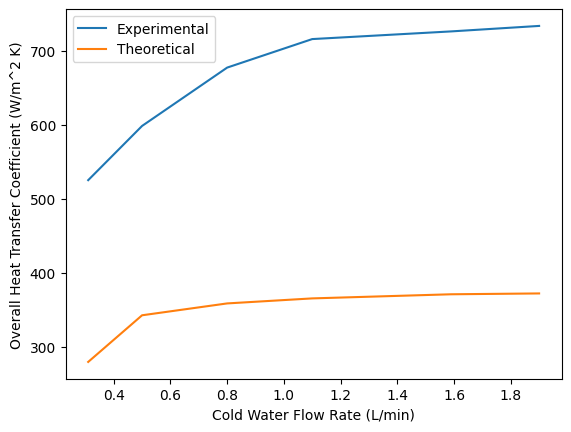

In [6]:
# create a plot for co-current cold water flow vs experimental and theoretical overall heat transfer coefficient
plt.figure()
plt.plot(co_cv, Uco_e, label='Experimental')
plt.plot(co_cv, Uco_t, label='Theoretical')
plt.xlabel('Cold Water Flow Rate (L/min)')
plt.ylabel('Overall Heat Transfer Coefficient (W/m^2 K)')
plt.legend()
plt.savefig('co.png', bbox_inches='tight')

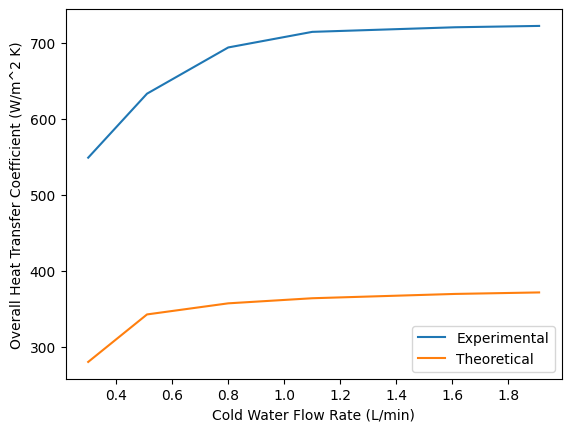

In [7]:
plt.figure()
plt.plot(cc_cv, Ucc_e, label='Experimental')
plt.plot(cc_cv, Ucc_t, label='Theoretical')
plt.xlabel('Cold Water Flow Rate (L/min)')
plt.ylabel('Overall Heat Transfer Coefficient (W/m^2 K)')
plt.legend()
plt.savefig('cc.png', bbox_inches='tight')

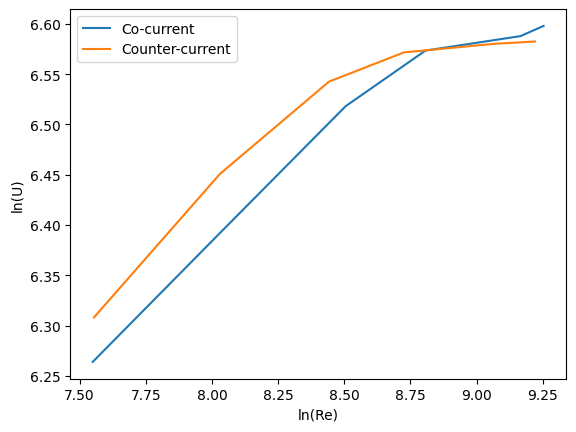

In [8]:
log_reshell_co = [math.log(i) for i in Reshell_co]
log_reshell_cc = [math.log(i) for i in Reshell_cc]
log_Uco_e = [math.log(i) for i in Uco_e]
log_Ucc_e = [math.log(i) for i in Ucc_e]
plt.figure()
plt.plot(log_reshell_co, log_Uco_e, label='Co-current')
plt.plot(log_reshell_cc, log_Ucc_e, label='Counter-current')
plt.xlabel('ln(Re)')
plt.ylabel('ln(U)')
plt.legend()

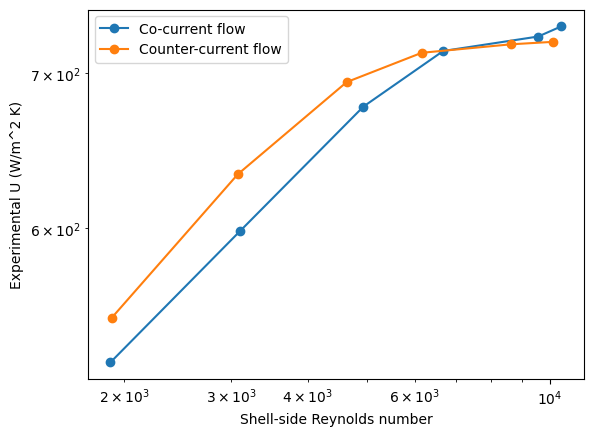

In [9]:
#Create a log-log plot of the experimental heat transfer coefficient versus the shell-side Reynolds number
plt.figure()
# convert to log scale
plt.loglog(Reshell_co, Uco_e, 'o-', label='Co-current flow')
plt.loglog(Reshell_cc, Ucc_e, 'o-', label='Counter-current flow')
plt.xlabel('Shell-side Reynolds number')
plt.ylabel('Experimental U (W/m^2 K)')
plt.legend()
plt.savefig('U_vs_Reshell.png', bbox_inches='tight')



In [15]:
# print the dataframes to three decimal places
print(co_df.round(3))
# print average heat transfer efficiency for co-current flow
print("Average heat transfer efficiency for co-current flow: ", sum(HTE_co)/len(HTE_co))

   Run       Qh       Qc  Total Energy Loss  Heat Transfer Efficiency
0    1  347.216  254.046             93.170                    73.167
1    2  418.710  385.346             33.365                    92.032
2    3  470.163  461.069              9.094                    98.066
3    4  504.502  511.951             -7.449                   101.476
4    5  532.042  508.168             23.874                    95.513
5    6  580.329  595.218            -14.889                   102.566
Average heat transfer efficiency for co-current flow:  93.80315489916967


In [16]:
print(cc_df.round(3))
# print average heat transfer efficiency for counter-current flow
print("Average heat transfer efficiency for counter-current flow: ", sum(HTE_cc)/len(HTE_cc))

   Run       Qh       Qc  Total Energy Loss  Heat Transfer Efficiency
0    1  428.711  374.714             53.998                    87.405
1    2  487.255  488.969             -1.714                   100.352
2    3  545.772  556.277            -10.505                   101.925
3    4  569.947  597.062            -27.115                   104.757
4    5  597.558  628.008            -30.450                   105.096
5    6  607.946  625.458            -17.512                   102.881
Average heat transfer efficiency for counter-current flow:  100.4024857531622


In [17]:
print(co_df2.round(3))
# print average error for co-current flow
print("Average error for co-current flow: ", sum(Uco_error)/len(Uco_error))

   Run        Q       Ue       Ut   Error
0    1  300.631  525.214  279.659  87.805
1    2  402.028  598.474  342.676  74.647
2    3  465.616  677.295  358.694  88.822
3    4  508.226  715.822  365.479  95.859
4    5  520.105  726.190  371.047  95.714
5    6  587.773  733.592  372.181  97.106
Average error for co-current flow:  89.99223710477088


In [18]:
print(cc_df2.round(3))
print("Average error for counter-current flow: ", sum(Ucc_error)/len(Ucc_error))

   Run        Q       Ue       Ut   Error
0    1  401.712  549.019  280.327  95.850
1    2  488.112  633.206  342.803  84.714
2    3  551.024  694.014  357.401  94.183
3    4  583.505  714.528  364.096  96.247
4    5  612.783  720.569  369.775  94.867
5    6  616.702  722.342  371.745  94.311
Average error for counter-current flow:  93.36203621265894


In [19]:
print("average error for both co-current and counter-current flow: ", (sum(Uco_error)+sum(Ucc_error))/(len(Uco_error)+len(Ucc_error)))

average error for both co-current and counter-current flow:  91.6771366587149
